# 1. Objetivo

## Problemática

El Tomato Yellow Leaf Curl Virus (TYLCV) es considerado una de las virosis más devastadoras del tomate a nivel global, generando pérdidas económicas significativas en la agricultura. Se estima que, incluso en regiones con buenas prácticas de manejo como Estados Unidos y Europa, el impacto del TYLCV puede suponer hasta un 20% de la producción anual, lo que representa cientos de millones de dólares en pérdidas. En zonas tropicales y subtropicales, donde las condiciones favorecen la propagación del vector, las infecciones pueden llegar a destruir el 100% de la cosecha en situaciones extremas (Glick et al., 2009; Yan et al., 2021).

Uno de los principales retos para el control del TYLCV es la detección temprana. Los síntomas visibles, como el amarilleo y rizado de hojas, pueden tardar hasta tres semanas en aparecer tras la infección, permitiendo así que el virus se disperse inadvertidamente entre los cultivos. Además, la transmisión eficiente por la mosca blanca Bemisia tabaci, sumada a la rápida adquisición y diseminación del virus, complica el manejo en campo. El uso intensivo de insecticidas tampoco es una solución sostenible, ya que la mosca blanca desarrolla resistencias y se refugia en malezas u otros cultivos, actuando como reservorio permanente del virus (Li et al., 2022; Yan et al., 2021).



La detección temprana y automatizada mediante imágenes y algoritmos de inteligencia artificial, especialmente modelos generativos como las GANs, representa una solución disruptiva para el problema. Mientras la inspección visual tradicional suele ser subjetiva y poco eficiente en grandes extensiones de cultivo, los sistemas automáticos pueden analizar grandes volúmenes de imágenes en tiempo real, identificando incluso señales sutiles o precoces de la infección. Los modelos GAN, en particular, permiten modelar el aspecto normal de la planta y resaltar anomalías producidas por el TYLCV, facilitando una intervención rápida antes de que el brote se generalice, incluso cuando hay pocos ejemplos de enfermedad etiquetada (Kaur, 2024; Yan et al., 2021).

## Objetivo del Proyecto

Entrenar un modelo generativo adversario (GAN) con imágenes de plantas de tomate sanas y con TYLCV para detectar automáticamente anomalías visuales indicativas de esta virosis en etapas iniciales. Se justifica el uso de GAN frente a clasificadores tradicionales porque este enfoque aprende a modelar la apariencia normal de la planta y puede destacar desviaciones sutiles causadas por el virus sin requerir un gran volumen de imágenes etiquetadas de enfermedad, lo que permite una identificación más temprana y flexible de nuevos casos.

# 2. Carga de los datos 

Las imágenes empleadas en este trabajo fueron extraídas del PlantVillage Dataset.
Siendo consistente con las indicaciones del repositorio original, se cita el siguiente artículo:

Mohanty, S. P., Hughes, D. P., & Salathé, M. (2016). Using deep learning for image-based plant disease detection. Frontiers in Plant Science, 7, 1419. https://doi.org/10.3389/fpls.2016.01419

# 3. Preparación de los Datos

### Librerias necesarias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from torch.optim import Adam
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split, Subset
import seaborn as sns
import torch
from collections import Counter
import random


### Redimencion y Normalizacion de imagenes


In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),           # Redimensiona a 224x224
    transforms.ToTensor(),                   # Convierte a tensor y normaliza a [0, 1]
    transforms.Normalize([0.5]*3, [0.5]*3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),# Normaliza a [-1, 1] (opcional, recomendado para GANs)
])

dataset = ImageFolder(root="../data/", transform=transform)

healthy_idx = dataset.class_to_idx['healthy']
anomaly_idx = dataset.class_to_idx['anomaly']

print(dataset.class_to_idx)
print(f"Total imágenes: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


{'anomaly': 0, 'healthy': 1}
Total imágenes: 3362


### Visualizacion inicial de los datos


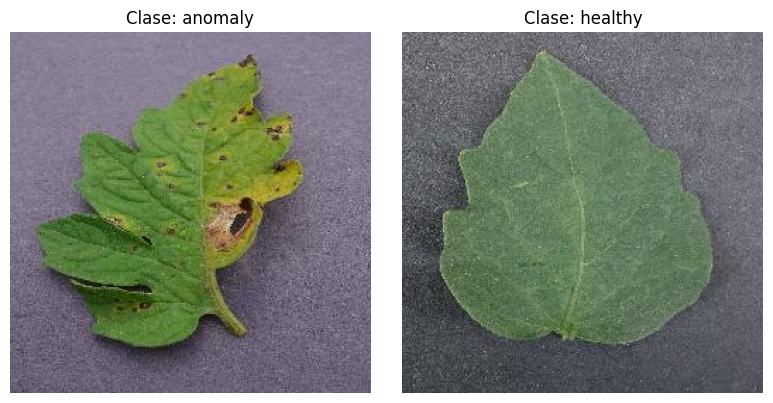

In [4]:

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for idx, class_name in enumerate(dataset.classes):
    for i, (path, label) in enumerate(dataset.samples):
        if label == idx:
            img_path = path
            break
    img = plt.imread(img_path)
    axs[idx].imshow(img)
    axs[idx].set_title(f"Clase: {class_name}")
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

Clase: anomaly - Cantidad de imágenes: 1771
Clase: healthy - Cantidad de imágenes: 1591


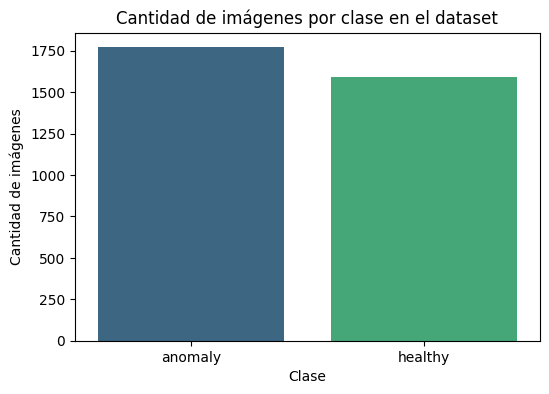

In [5]:
labels, counts = np.unique([label for _, label in dataset.samples], return_counts=True)
class_names = [dataset.classes[i] for i in labels]


for name, count in zip(class_names, counts):
    print(f"Clase: {name} - Cantidad de imágenes: {count}")

plt.figure(figsize=(6,4))
sns.barplot(x=class_names, y=counts, palette="viridis", hue=class_names)
plt.title("Cantidad de imágenes por clase en el dataset")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.show()

### Configuración general

In [6]:
device = 'cuda'
latent_dim = 128
img_size = 64
batch_size = 64
lr = 2e-4
epochs = 100

#### Division de data

In [7]:
# Esto obtiene los índices de cada imagen que pertenece a cada clase
healthy_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == healthy_idx]
anomaly_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == anomaly_idx]


In [30]:

train_indices = random.sample(healthy_indices, int(0.8 * len(healthy_indices)))
val_indices = list(set(healthy_indices) - set(train_indices))
test_indices = val_indices + anomaly_indices
# Seleccionar la misma cantidad de anomalías que de imágenes sanas para el test
anomaly_indices_sampled = random.sample(anomaly_indices, len(val_indices))
test_indices = val_indices + anomaly_indices_sampled


In [31]:
train_set = Subset(dataset, train_indices)
test_set = Subset(dataset, test_indices)
test_labels = [dataset.samples[i][1] for i in test_indices]

In [32]:

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size)

# 4. Arquitectura del Modelo

Se usará una f-AnoGAN que es una versión mas eficiente y moderna de una AnoGAN. 

Schlegl, T., Seeböck, P., Waldstein, S. M., Schmidt-Erfurth, U., & Langs, G. (2019). f-AnoGAN: Fast unsupervised anomaly detection with generative adversarial networks. Medical Image Analysis, 54, 30-44.

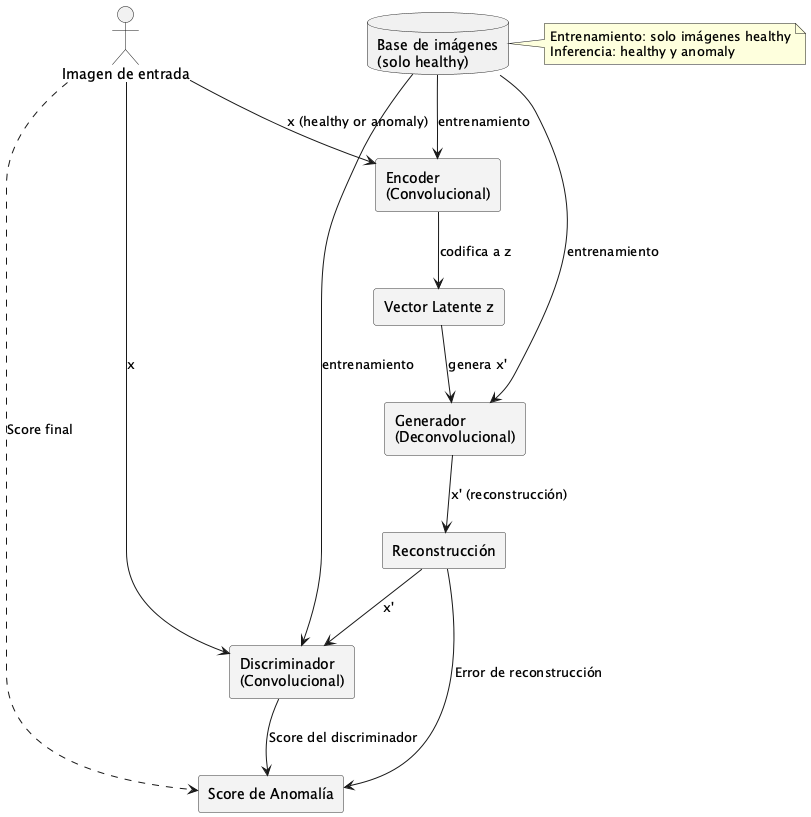

# 5. Modelo GAN

## Encoder

In [33]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(256*8*8, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

## Decoder

In [34]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256*8*8),
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 256, 8, 8)
        return self.deconv(x)

## Descriminator

In [35]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(256*8*8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instanciar modelos

In [36]:
E = Encoder().to(device)
G = Decoder().to(device)
E2 = Encoder().to(device)
D = Discriminator().to(device)

opt_EG = Adam(list(E.parameters()) + list(G.parameters()) + list(E2.parameters()), lr=lr, betas=(0.5, 0.999))
opt_D = Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()


In [37]:
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
Is CUDA available: True


## Entrenamiento

In [38]:
from tqdm import tqdm



loop = tqdm(range(epochs), desc="Entrenando GAN")
for epoch in loop:
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # ---- Train Discriminator ----
        z = E(imgs)
        recon = G(z)
        D_real = D(imgs)
        D_fake = D(recon.detach())
        loss_D = (bce_loss(D_real, valid) + bce_loss(D_fake, fake)) / 2

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

         # ---- Train Generator + Encoders ----
        z = E(imgs)
        recon = G(z)
        z_ = E2(recon)

        loss_adv = bce_loss(D(recon), valid)
        loss_con = mse_loss(recon, imgs)
        loss_enc = torch.mean(torch.abs(z - z_))

        loss_G = loss_con + loss_enc + 0.1 * loss_adv

        opt_EG.zero_grad()
        loss_G.backward()
        opt_EG.step()

    loop.set_postfix(D_loss=loss_D.item(), G_loss=loss_G.item())

Entrenando GAN:  21%|██        | 21/100 [02:16<08:31,  6.48s/it, D_loss=0.102, G_loss=0.711] 


KeyboardInterrupt: 

##  Evaluación


[[ 303   16]
 [1485  286]]
              precision    recall  f1-score   support

     healthy       0.17      0.95      0.29       319
     anomaly       0.95      0.16      0.28      1771

    accuracy                           0.28      2090
   macro avg       0.56      0.56      0.28      2090
weighted avg       0.83      0.28      0.28      2090

AUC: 0.8613078348665101


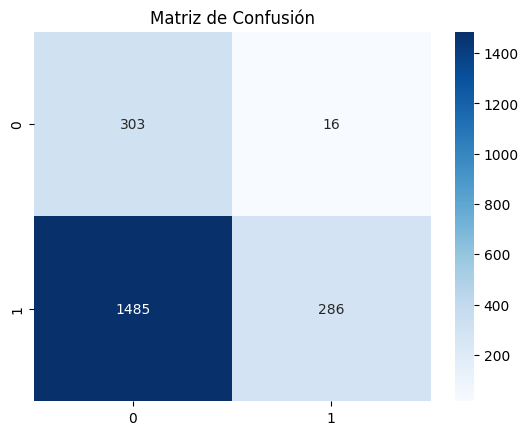

In [ ]:
E.eval(); G.eval(); E2.eval()
scores = []
true_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        z = E(imgs)
        recon = G(z)
        z_ = E2(recon)

        score = torch.mean((imgs - recon) ** 2, dim=[1,2,3]) + torch.mean(torch.abs(z - z_), dim=1)
        scores.extend(score.cpu().numpy())
        true_labels.extend(labels.numpy())

# Calcular umbral
healthy_scores = [s for s, l in zip(scores, true_labels) if l == healthy_idx]
threshold = np.percentile(healthy_scores, 95)

preds = [1 if s > threshold else 0 for s in scores]  # 1 = anomaly
bin_labels = [1 if l == anomaly_idx else 0 for l in true_labels]




## Graficos

In [ ]:
from sklearn.metrics import roc_curve, auc

<Axes: >

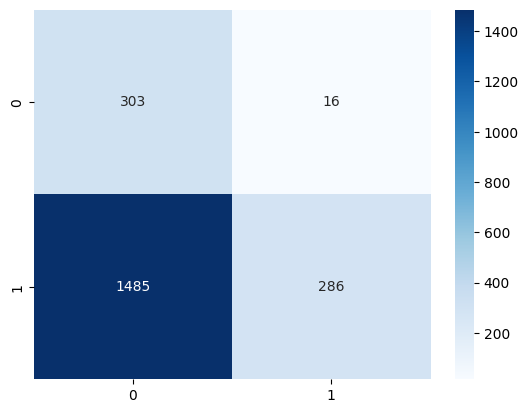

In [ ]:
sns.heatmap(confusion_matrix(bin_labels, preds), annot=True, fmt='d', cmap='Blues')

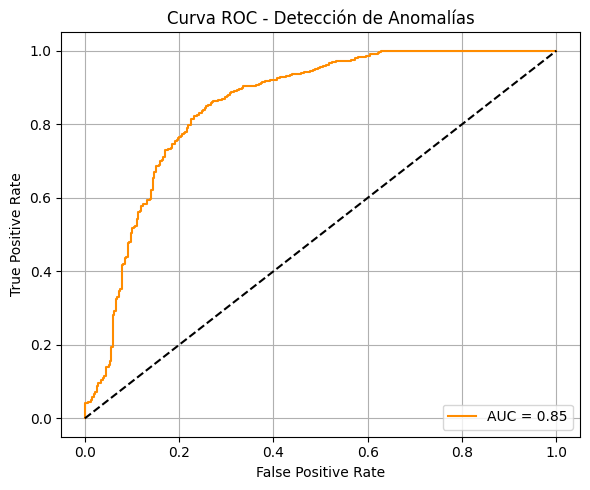

In [ ]:
fpr, tpr, _ = roc_curve(bin_labels, scores)
roc_auc = auc(fpr, tpr)

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Detección de Anomalías")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

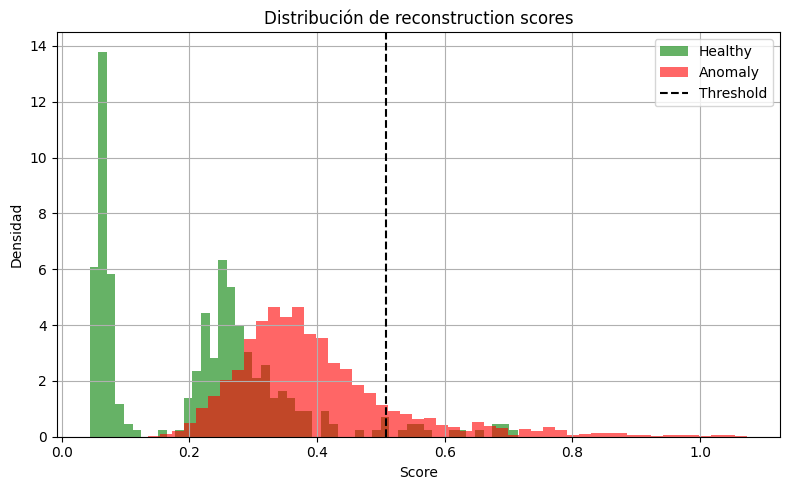

In [ ]:
# Separar scores por clase
scores_healthy = [s for s, l in zip(scores, true_labels) if l == healthy_idx]
scores_anomaly = [s for s, l in zip(scores, true_labels) if l == anomaly_idx]

plt.figure(figsize=(8, 5))
plt.hist(scores_healthy, bins=50, alpha=0.6, label="Healthy", density=True, color="green")
plt.hist(scores_anomaly, bins=50, alpha=0.6, label="Anomaly", density=True, color="red")
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.title("Distribución de reconstruction scores")
plt.xlabel("Score")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 9. Acciones